# b站-Node2Vec图嵌入

## 安装工具包

In [1]:
# !pip install node2vec networkx numpy matplotlib

## 导入工具包

In [2]:
import networkx as nx # 图数据挖掘
import numpy as np # 数据分析
import random # 随机数

# 数据可视化
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签  
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
import pandas as pd

## 导入数据集

In [3]:
# 空手道俱乐部数据集
# G = nx.karate_club_graph()

In [4]:
df = pd.read_csv("./data/bilibili_tag2.csv", sep="\t")
print(df.isnull().sum())
df = df.dropna()
G = nx.from_pandas_edgelist(df,df.columns[0], df.columns[1], create_using=nx.Graph())

A    0
B    0
dtype: int64


In [5]:
G.nodes

NodeView(('科技', '万物研究所', '知识', '科学科普', '人类史', '科学史', 'FOXP2', '智人', '科技史', '工具', '原始人', '走出非洲', '尼安德特人', '万物研究所·第九期', '生物', '科学', '科普', '自然', '万物研究所·第十期', '鉴定', '人工智能', '互联网', '学习', '流行音乐', '华语音乐', '研究', '数据', '傅里叶变换', '万物研究所·第七期', '深度学习', '眼镜', '医学', '健康', '搞笑', '医案寻踪', '骗局', '沙雕', '近视', '万物研究所·2022第五期', '灾难', '非洲', '疾病', '埃博拉病毒', '瘟疫', '病毒', '化学', '实验', '鸡', '坤坤', 'ikun', '鸡你太美', '我们都爱搞学习', '高考', '校园学习', '复习', '高中', '高中生物', '经验分享', '学习心得', '我们都爱搞学习·第二期', '考试', '大学', '校园', '学生党', '摆烂', '必剪创作', '基础知识', '易错点', '知识点', '恐龙', '剪辑', '生命', '古生物', '史前星球', '年表', '打卡挑战', '复习提纲朗读', '知识点梳理朗读', '初中生物', '中考生物', '生物知识点', '社会洞察计划', '冷知识', '人文', '社科·法律·心理', '趣闻', '星海计划', '干货', '大力王', '心理学知识', '高三', '课程', '逆袭', '遗传', '天文', '地理', '量子', '祖师爷', '全能打卡挑战', '天文学', '科学很可爱', '科学中穿梭', '历史的遗憾', '遗憾', '科学家', '涨知识', '2023科学很可爱', '正经的知识又增加了', '视频教程', '儿童', '少儿', '儿童教育', '宇宙', '休谟问题', '贝叶斯主义', '奥卡姆剃刀', '进化论', '科学哲学', '贝叶斯', '知识分享官', '物理', '物质', '科学实验', '心理学', '社会', '女生', '记忆力', '男生', '思维', '自信', '历史', '影视', '影视杂谈', 

In [6]:
len(G)

1234

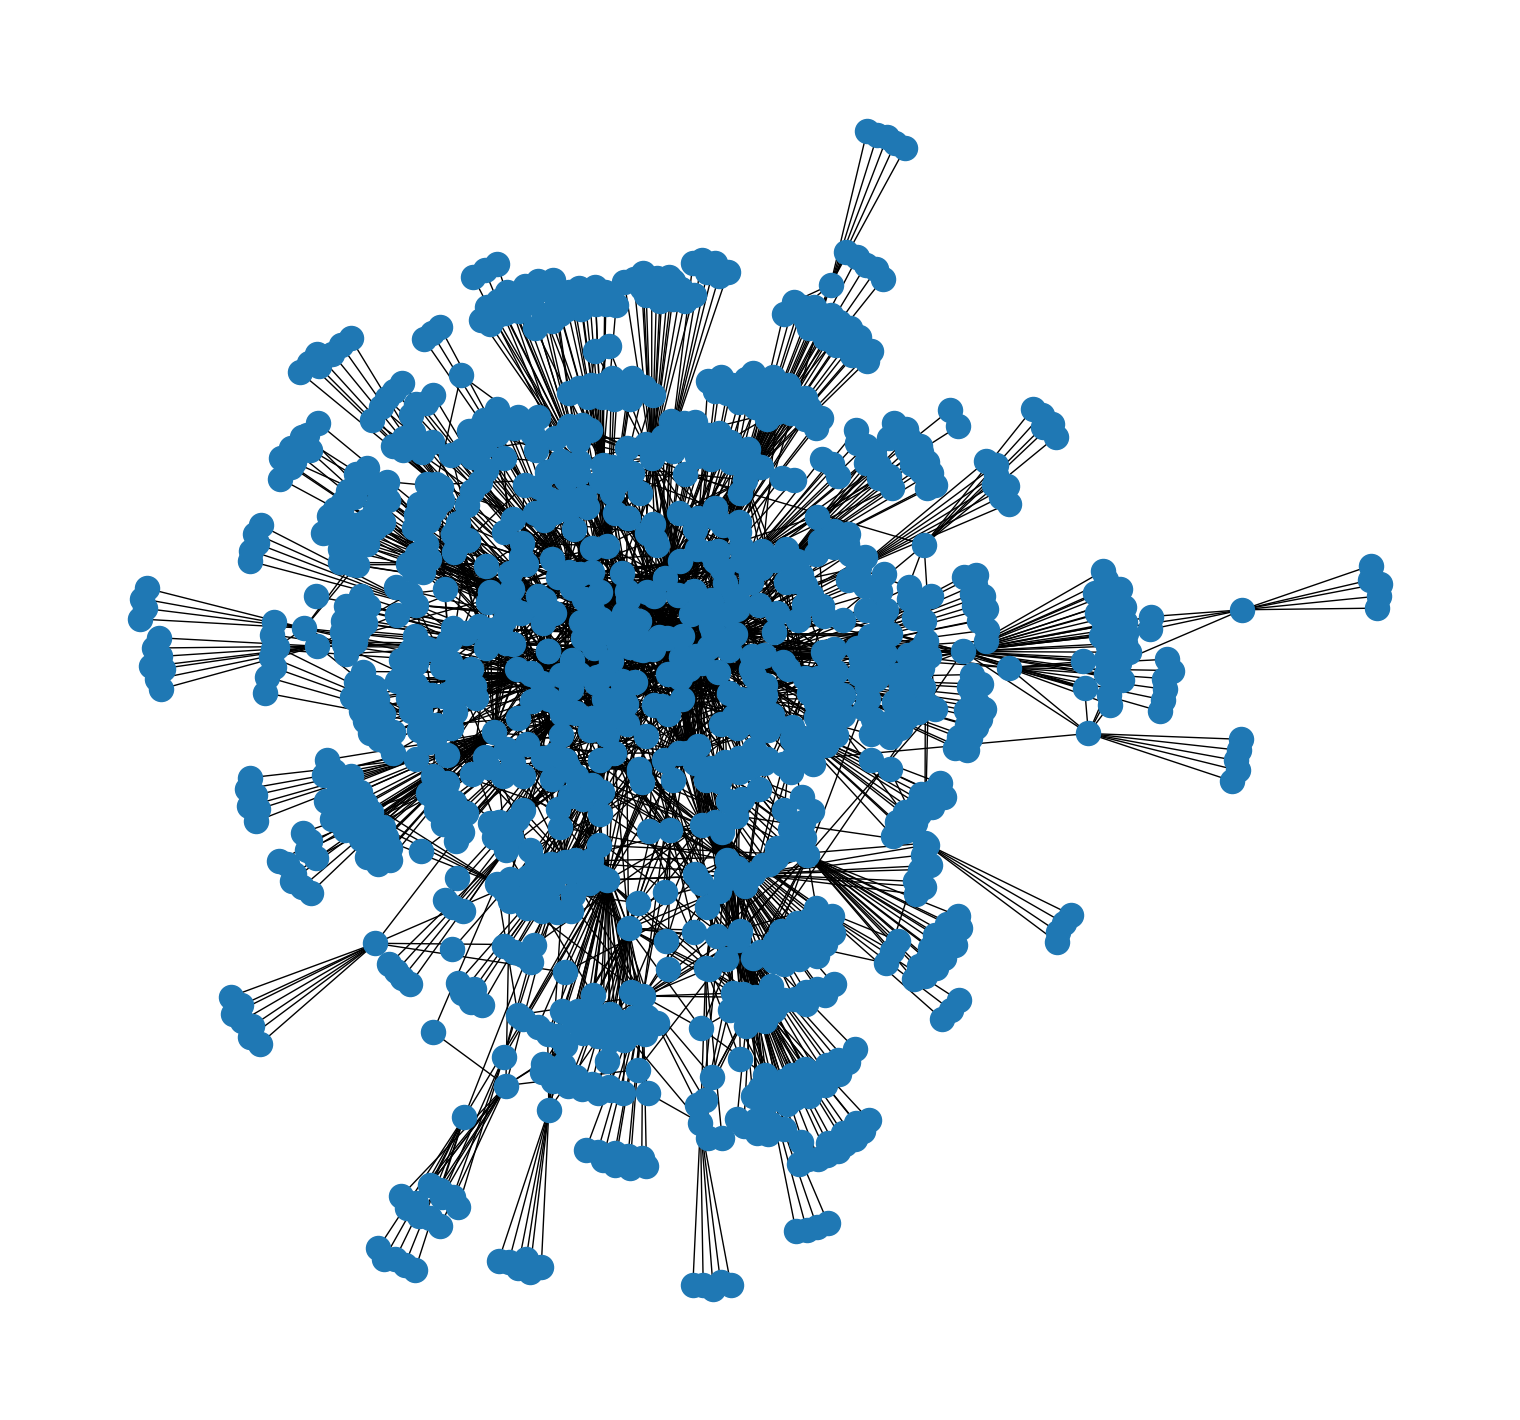

In [7]:
# 可视化
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=5)
nx.draw(G, pos, with_labels=False)
plt.show()

## 构建Node2Vec模型

In [8]:
from node2vec import Node2Vec

In [9]:
# 设置node2vec参数
node2vec = Node2Vec(G, 
                    dimensions=32,  # 嵌入维度
                    p=1,            # 回家参数
                    q=0.5,          # 外出参数
                    walk_length=5, # 随机游走最大长度
                    num_walks=100,  # 每个节点作为起始节点生成的随机游走个数
                    workers=4       # 并行线程数
                   )

# p=1, q=0.5, n_clusters=6。DFS深度优先搜索，挖掘同质社群
# p=1, q=2, n_clusters=3。BFS宽度优先搜索，挖掘节点的结构功能。

# 训练Node2Vec，参数文档见 gensim.models.Word2Vec
model = node2vec.fit(window=1,    # Skip-Gram窗口大小
                     min_count=1,  # 忽略出现次数低于此阈值的节点（词）
                     batch_words=4 # 每个线程处理的数据量
                    )
X = model.wv.vectors

Computing transition probabilities:   0%|          | 0/1234 [00:00<?, ?it/s]

In [10]:
X.shape

(1234, 32)

## 节点Embedding聚类可视化

### 运行聚类

Kmeans聚类算法讲解：https://www.bilibili.com/video/BV1HJ411P7cs

In [11]:
# # DBSCAN聚类
# from sklearn.cluster import DBSCAN
# cluster_labels = DBSCAN(eps=0.5, min_samples=6).fit(X).labels_
# print(cluster_labels)

# KMeans聚类
from sklearn.cluster import KMeans
import numpy as np
cluster_labels = KMeans(n_clusters=3).fit(X).labels_
print(cluster_labels)

[1 1 0 ... 1 1 1]


### 将networkx中的节点和词向量中的节点对应

将词汇表的节点顺序转为networkx中的节点顺序

In [12]:
colors = []
nodes = list(G.nodes)
for node in nodes: # 按 networkx 的顺序遍历每个节点
    idx = model.wv.key_to_index[str(node)] # 获取这个节点在 embedding 中的索引号
    colors.append(cluster_labels[idx]) # 获取这个节点的聚类结果

### 可视化聚类效果

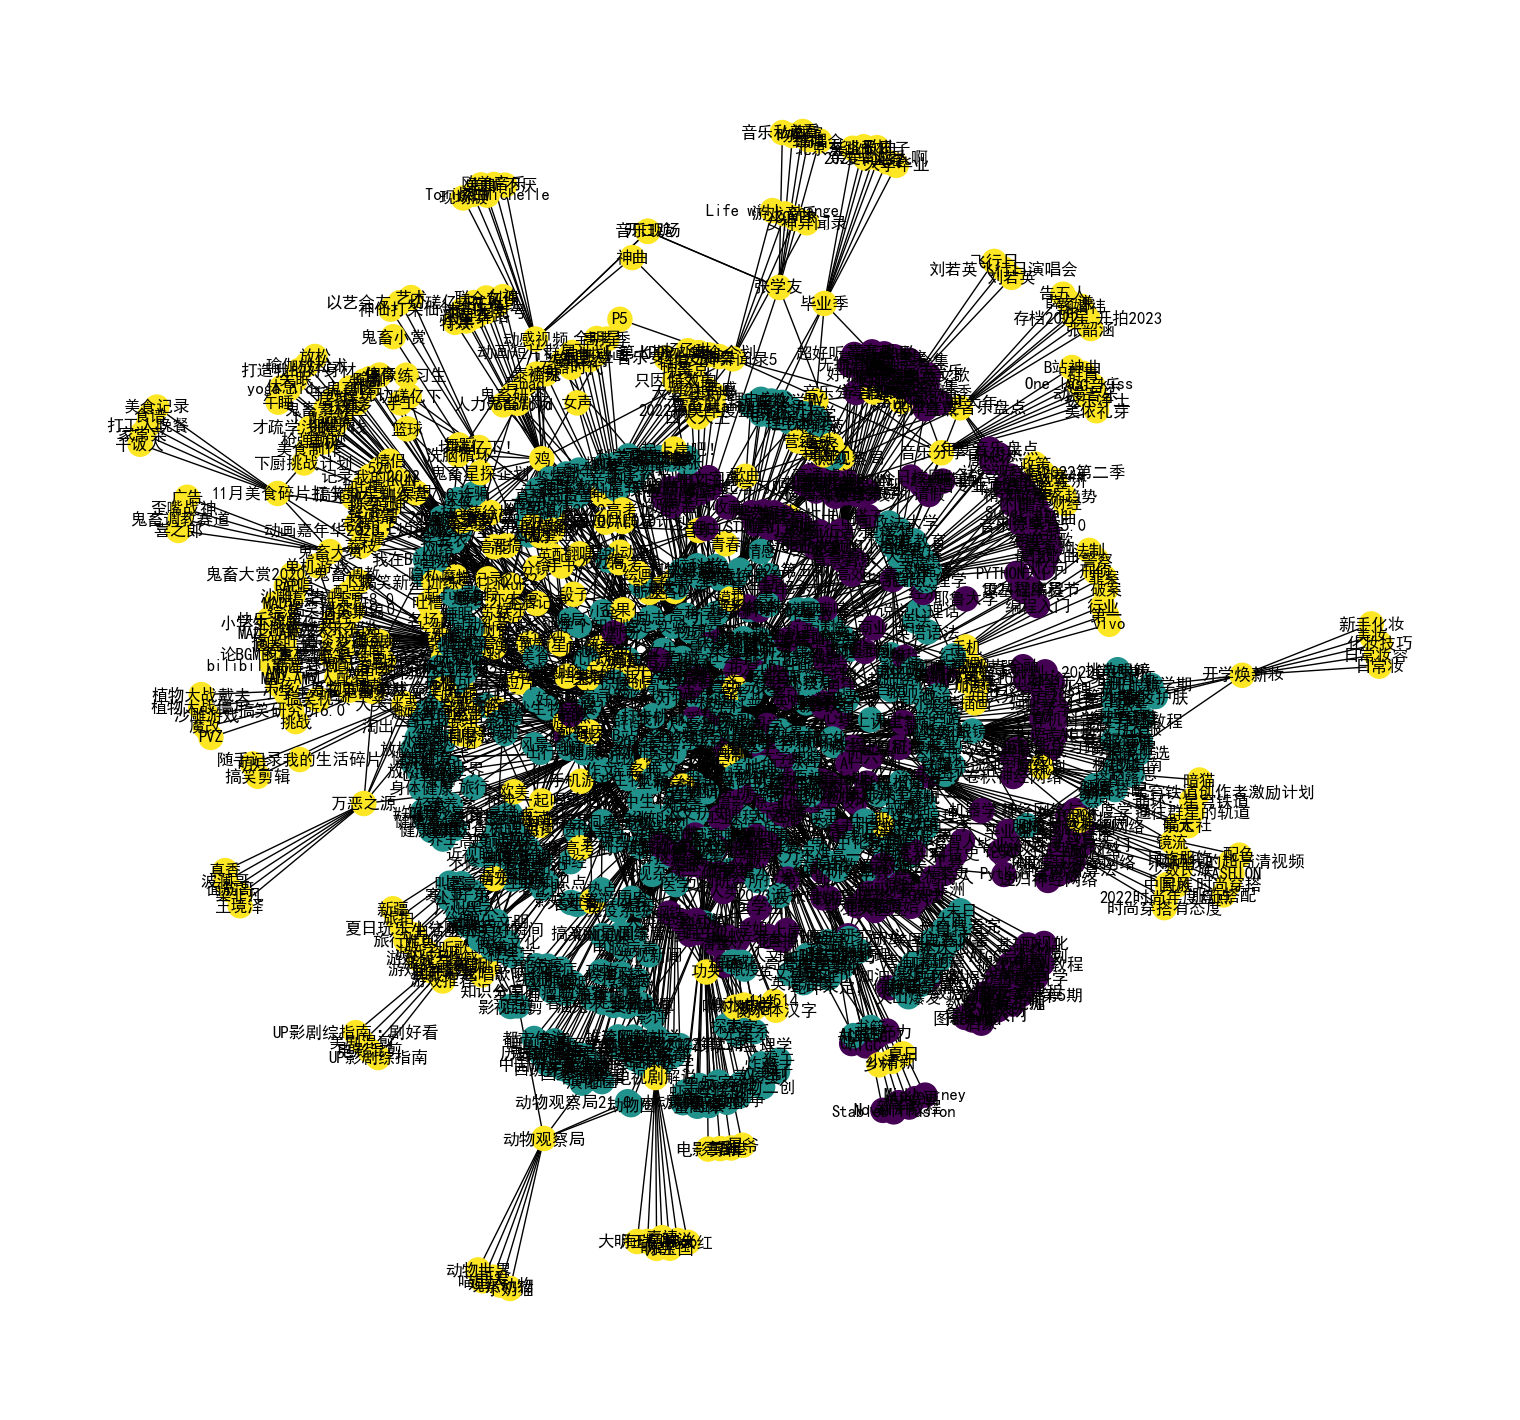

In [13]:
plt.figure(figsize=(15,14))
pos = nx.spring_layout(G, seed=10)
nx.draw(G, pos, node_color=colors, with_labels=True)
plt.show()

## 查看Embedding

In [14]:
model.wv.get_vector('手机').shape

(32,)

In [15]:
# 查看某个节点的Embedding
model.wv.get_vector('手机')

array([ 7.4415199e-02, -1.2434044e+00, -4.0288779e-01,  3.9708507e-01,
       -3.1712630e-01,  2.4588291e-01,  7.5378001e-01,  1.2656283e+00,
       -2.7425230e-01, -1.7355381e-01,  4.3856275e-01, -1.6927601e+00,
        5.3710145e-01, -2.7757126e-01, -1.2774432e-01, -2.0243116e-01,
       -2.6541203e-02, -1.9007327e-01, -1.0635378e-03, -2.7471083e-01,
        2.4982642e-01,  1.9859178e+00,  1.2074323e+00, -1.9821005e-01,
       -8.3868831e-01, -7.5593036e-01, -1.1583730e+00, -1.2208326e-01,
        5.1281375e-01, -7.0413131e-01,  2.2039250e-01, -5.7917392e-01],
      dtype=float32)

In [16]:
# 查找节点的相似节点
model.wv.most_similar('数码')

[('技术宅', 0.8332101106643677),
 ('手机', 0.7916712760925293),
 ('科技猎手计划2022第二季', 0.7876229286193848),
 ('野生技术协会', 0.772271454334259),
 ('APP推荐', 0.7510901689529419),
 ('漫画', 0.7488031983375549),
 ('PYTHON教程', 0.744411289691925),
 ('运营产品', 0.7425751090049744),
 ('大数据', 0.7396265268325806),
 ('加速器', 0.7380245327949524)]

In [17]:
# 查看任意两个节点的相似度
model.wv.similarity('数码', '手机')

0.7916713

In [18]:
# 查看任意两个节点的相似度DIY
model.wv.similarity('数码', '电影')

0.15868579

## 对Edge（连接）做Embedding

In [19]:
from node2vec.edges import HadamardEmbedder

In [20]:
# Hadamard 二元操作符：两个 Embedding 对应元素相乘
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [21]:
# 查看 任意两个节点连接 的 Embedding
edges_embs[('数码', '电影')]

array([-0.01568311,  0.18288156, -0.02559192, -0.12382559, -0.35254   ,
       -0.03021579,  0.3229161 , -0.33555236,  0.08366509,  0.12680465,
        0.11087055,  0.76437926,  0.5802587 , -0.06076343,  0.01241119,
       -0.12185465,  0.06949055, -0.03578024, -0.20406483, -0.26870006,
        0.48239502,  0.5944515 ,  0.59820205,  0.02485037, -0.02866535,
       -0.02056831,  0.51198334, -0.16324204, -0.6165018 , -0.05978726,
       -0.02032008,  0.00360279], dtype=float32)

In [22]:
# 计算所有 Edge 的 Embedding
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████████████████████████████████████| 761995/761995.0 [00:04<00:00, 157721.70it/s]


In [23]:
edges_kv.index_to_key

["('科普', '科普')",
 "('知识', '科普')",
 "('数据', '科普')",
 "('学习', '科普')",
 "('眼镜', '科普')",
 "('人文', '科普')",
 "('华语音乐', '科普')",
 "('科普', '自然')",
 "('沙雕', '科普')",
 "('科学科普', '科普')",
 "('科学', '科普')",
 "('冷知识', '科普')",
 "('健康', '科普')",
 "('研究', '科普')",
 "('流行音乐', '科普')",
 "('搞笑', '科普')",
 "('科普', '非洲')",
 "('人工智能', '科普')",
 "('瘟疫', '科普')",
 "('深度学习', '科普')",
 "('社会洞察计划', '科普')",
 "('ikun', '科普')",
 "('科普', '鸡你太美')",
 "('科普', '鉴定')",
 "('灾难', '科普')",
 "('社科·法律·心理', '科普')",
 "('万物研究所·第十期', '科普')",
 "('生物', '科普')",
 "('万物研究所·第七期', '科普')",
 "('生活', '科普')",
 "('互联网', '科普')",
 "('科普', '骗局')",
 "('科普', '近视')",
 "('医案寻踪', '科普')",
 "('万物研究所', '科普')",
 "('医学', '科普')",
 "('科普', '高考')",
 "('科普', '鸡')",
 "('病毒', '科普')",
 "('傅里叶变换', '科普')",
 "('科普', '音乐')",
 "('坤坤', '科普')",
 "('埃博拉病毒', '科普')",
 "('万物研究所·2022第五期', '科普')",
 "('科技', '科普')",
 "('疾病', '科普')",
 "('实验', '科普')",
 "('化学', '科普')",
 "('知识分享官', '科普')",
 "('校园学习', '科普')",
 "('历史', '科普')",
 "('科普', '资讯')",
 "('科普', '黑科技')",
 "('动感视频', '科普')",
 "('冥想', '科普'

In [24]:
# 查看 关系与 某两个节点 最相似的 节点对
edges_kv.most_similar(str(('数码', '电影')))

[("('亲情', '数码')", 0.9786699414253235),
 ("('数码', '白日梦想家')", 0.9784155488014221),
 ("('数码', '春日迷影电影院')", 0.9686092138290405),
 ("('数码', '美国电影')", 0.9645354747772217),
 ("('数码', '电影解说')", 0.9441916942596436),
 ("('科技猎手计划2022第二季', '美好生活日常记录')", 0.8462245464324951),
 ("('亲情', '教程')", 0.8421405553817749),
 ("('电影', '野生技术协会')", 0.8400982618331909),
 ("('影娱新春游园会', '数码')", 0.8350897431373596),
 ("('亲情', '野生技术协会')", 0.8339124917984009)]

## PCA降维可视化

### 可视化全部词条的二维Embedding¶

In [25]:
X = model.wv.vectors

In [26]:
# 将Embedding用PCA降维到2维
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(X)

In [27]:
embed_2d.shape

(1234, 2)

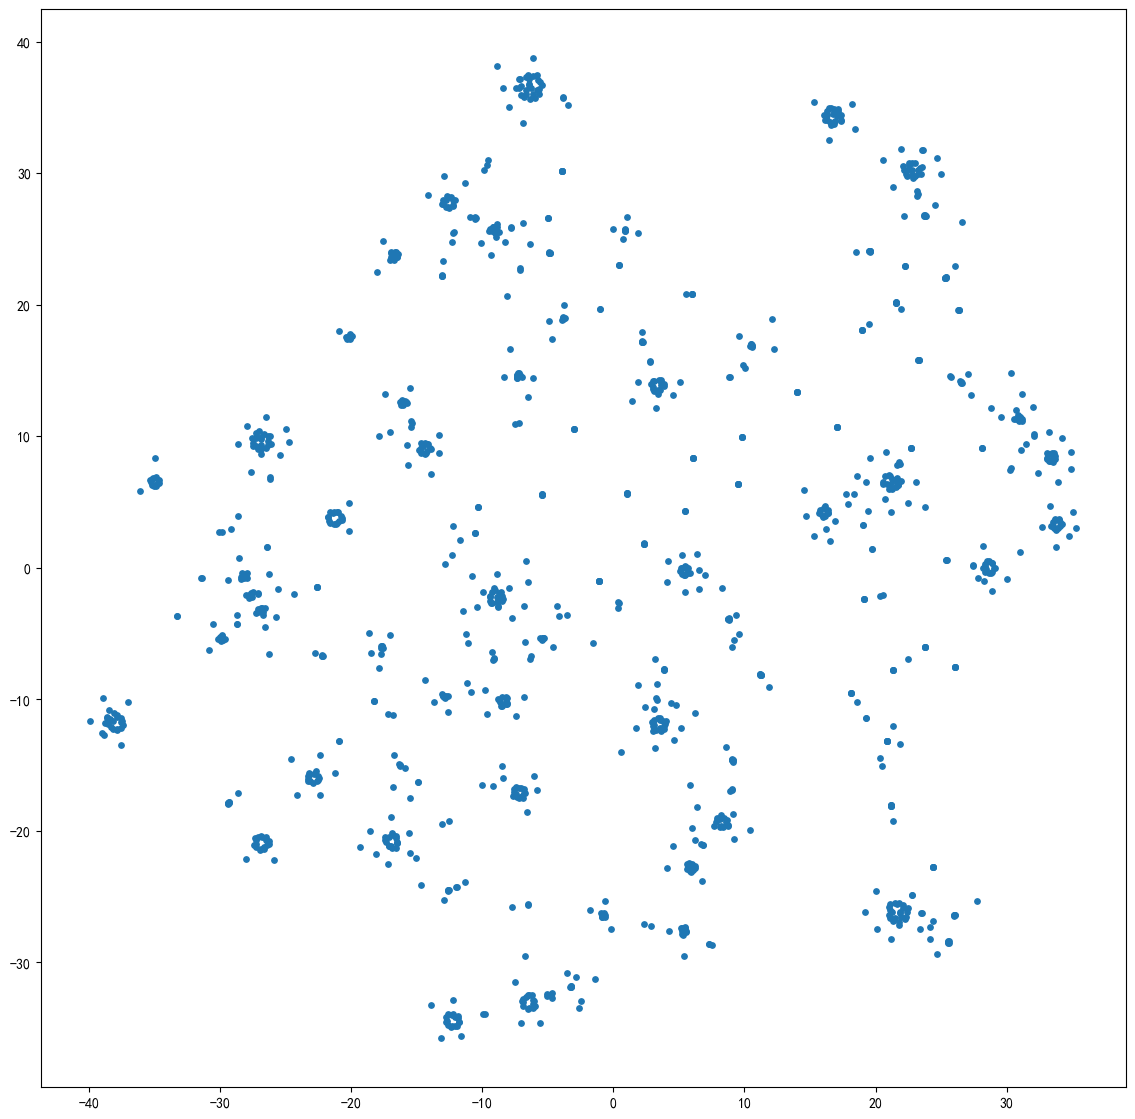

In [51]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1],s=15)
plt.show()

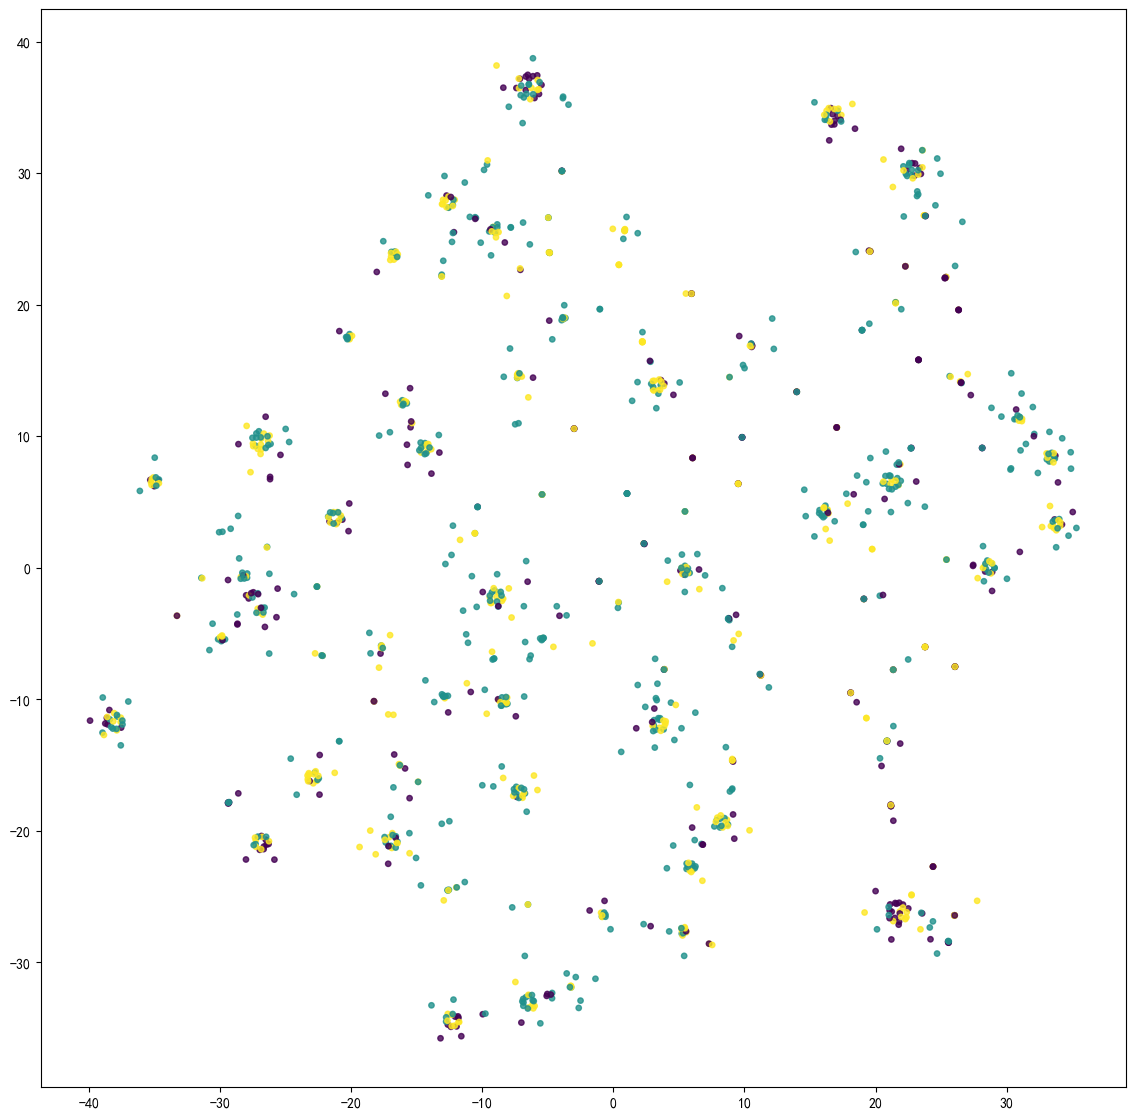

In [52]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=colors, alpha=0.8,s=15)
plt.show()

## TSNE降维可视化

### 可视化全部词条的二维Embedding¶

In [30]:
# 将Embedding用TSNE降维到2维
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, n_iter=1000)
embed_2d = tsne.fit_transform(X)

D:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


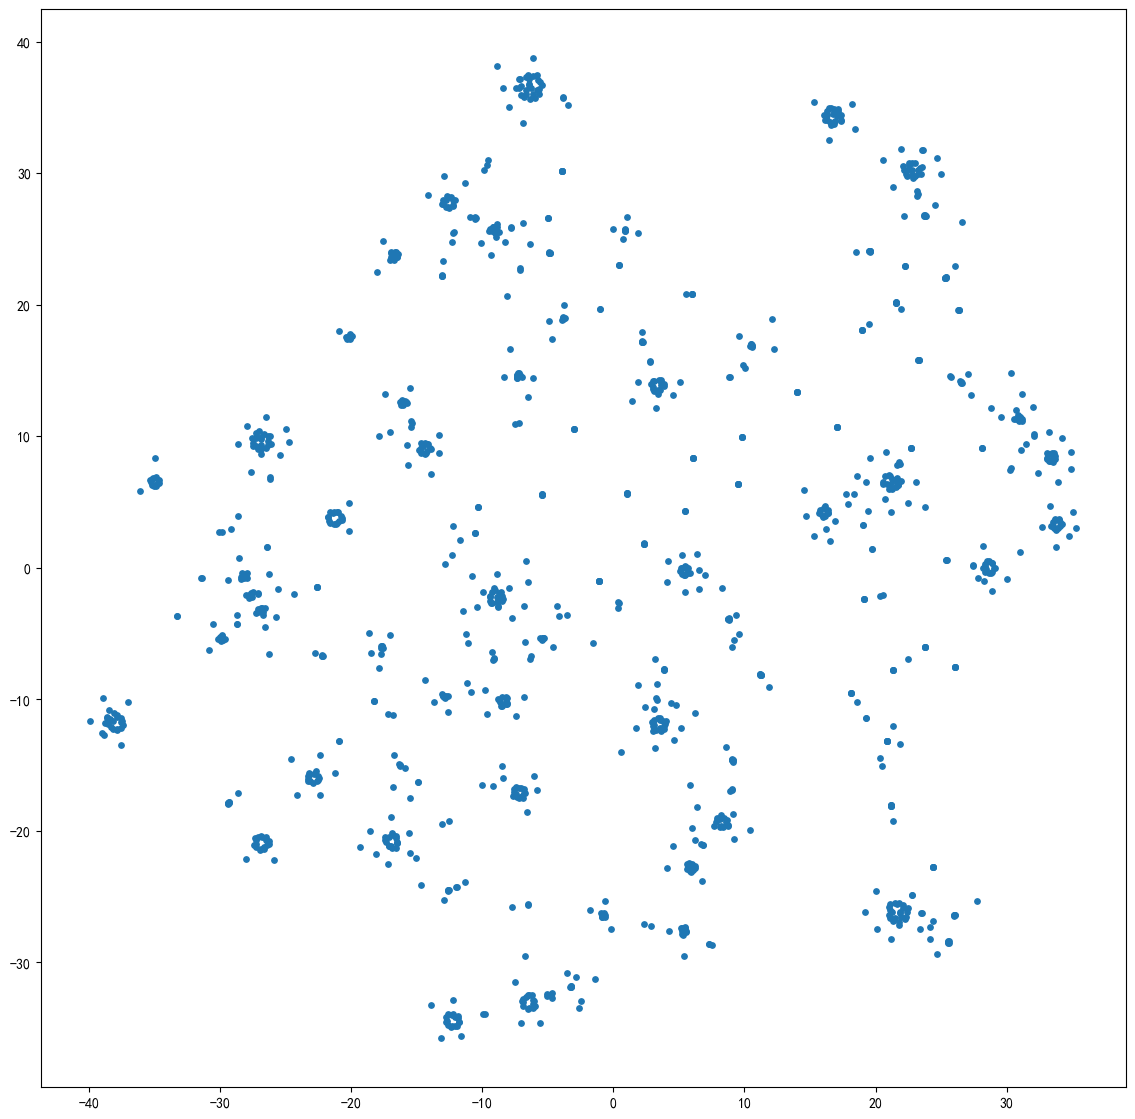

In [53]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1],s=15)
plt.show()

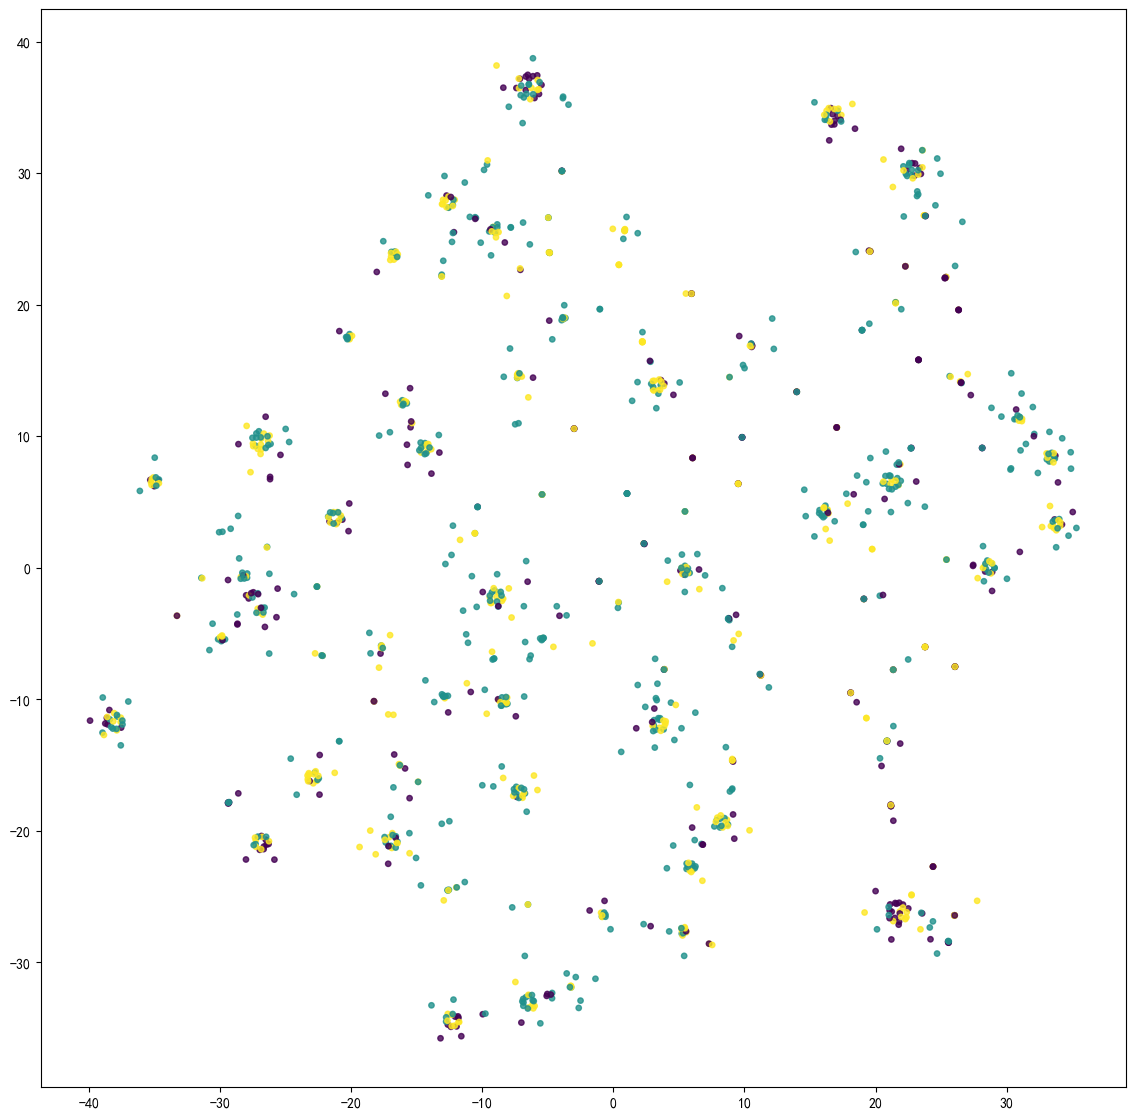

In [54]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=colors, alpha=0.8,s=15)
plt.show()

#可以看到TSNE降维可视化的效果更好一些

### 可视化某个词条的二维Embedding

In [33]:
term = '手机'

In [34]:
term_256d = model.wv[term].reshape(1,-1)

In [35]:
term_256d.shape

(1, 32)

In [36]:
term_2d = pca.transform(term_256d)

In [37]:
term_2d

array([[0.5068206, 0.6546267]], dtype=float32)

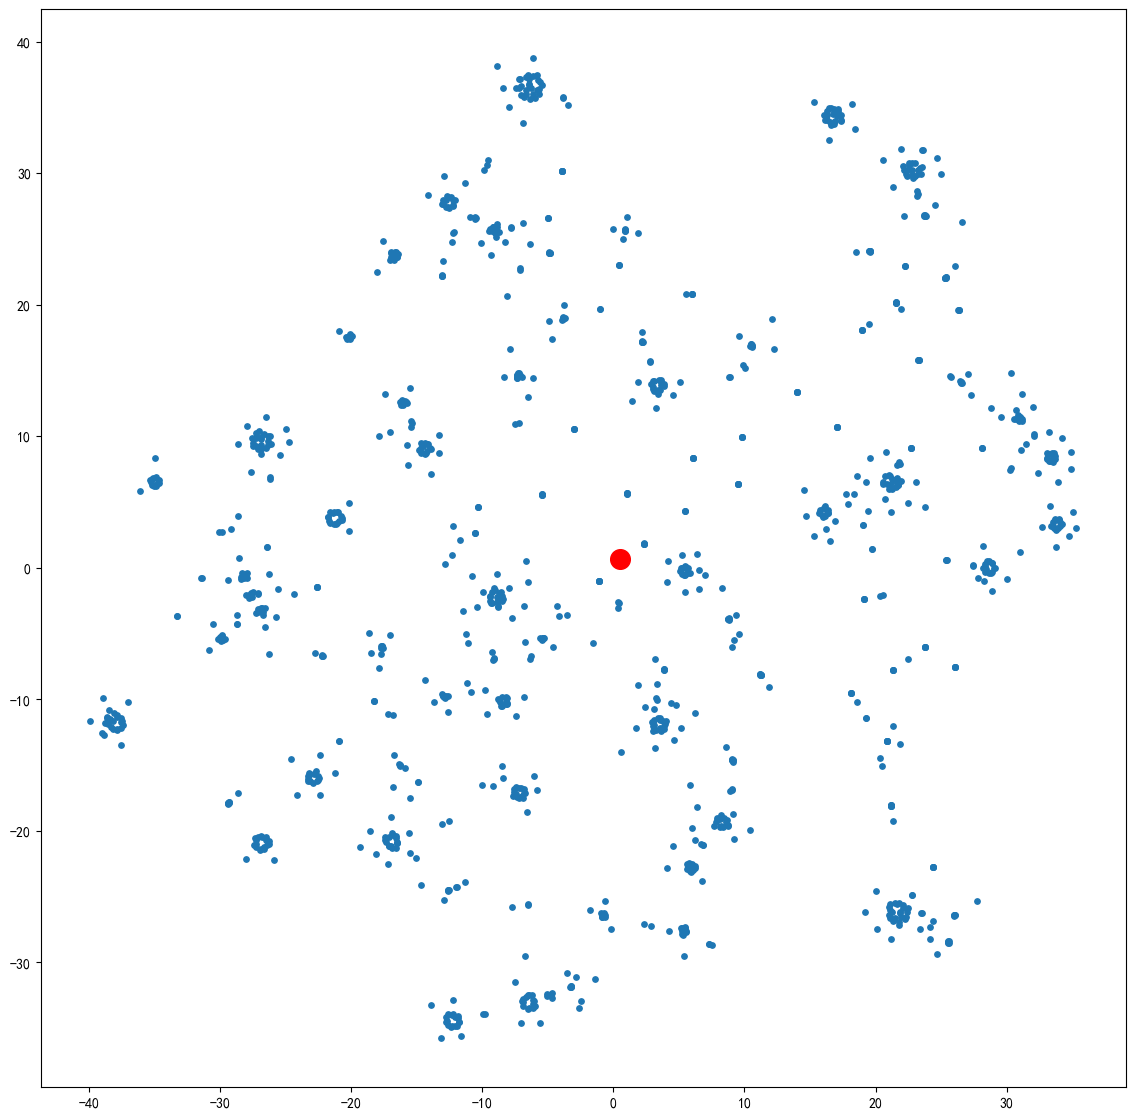

In [55]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1],s=15)
plt.scatter(term_2d[:,0],term_2d[:,1],c='r',s=200)
plt.show()

### 可视化某些词条的二维Embedding

In [39]:
# 计算PageRank重要度
pagerank = nx.pagerank(G)
# 从高到低排序
node_importance = sorted(pagerank.items(), key=lambda x:x[1], reverse=True)

In [40]:
# 取最高的前n个节点
n = 50
terms_chosen = []
for each in node_importance[:n]:
    terms_chosen.append(each[0])

In [41]:
# 手动补充新节点
# terms_chosen.extend(['computer vision','deep learning','convolutional neural network','convolution','natural-language processing','attention (machine learning)','support-vector machine','decision tree','random forest','computational imaging','machine vision','cognitive science','neuroscience','psychophysics','brain','visual cortex','visual neuroscience','cognitive model','finite difference','finite difference time domain','finite difference coefficients','finite difference methods for option pricing','iso 128','iso 10303'])


In [42]:
terms_chosen

['知识',
 '科普',
 '学习',
 '数据',
 '科学科普',
 '科学',
 '眼镜',
 '人文',
 '自然',
 '健康',
 '沙雕',
 '华语音乐',
 '研究',
 '冷知识',
 '搞笑',
 '流行音乐',
 '人工智能',
 '瘟疫',
 '非洲',
 '万物研究所·第十期',
 'ikun',
 '生物',
 '深度学习',
 '鸡你太美',
 '社会洞察计划',
 '社科·法律·心理',
 '灾难',
 '鉴定',
 '万物研究所·第七期',
 '生活',
 '万物研究所',
 '高考',
 '互联网',
 '骗局',
 '病毒',
 '鸡',
 '近视',
 '傅里叶变换',
 '医案寻踪',
 '坤坤',
 '医学',
 '埃博拉病毒',
 '音乐',
 '科技',
 '疾病',
 '万物研究所·2022第五期',
 '实验',
 '化学',
 '知识分享官',
 '校园学习']

### 可视化全部词条和关键词条的二维Embedding

In [43]:
# 输入词条，输出词典中的索引号
term2index = model.wv.key_to_index

In [44]:
# index2term = model.wv.index_to_key
# term_index = np.array(term2index.values())

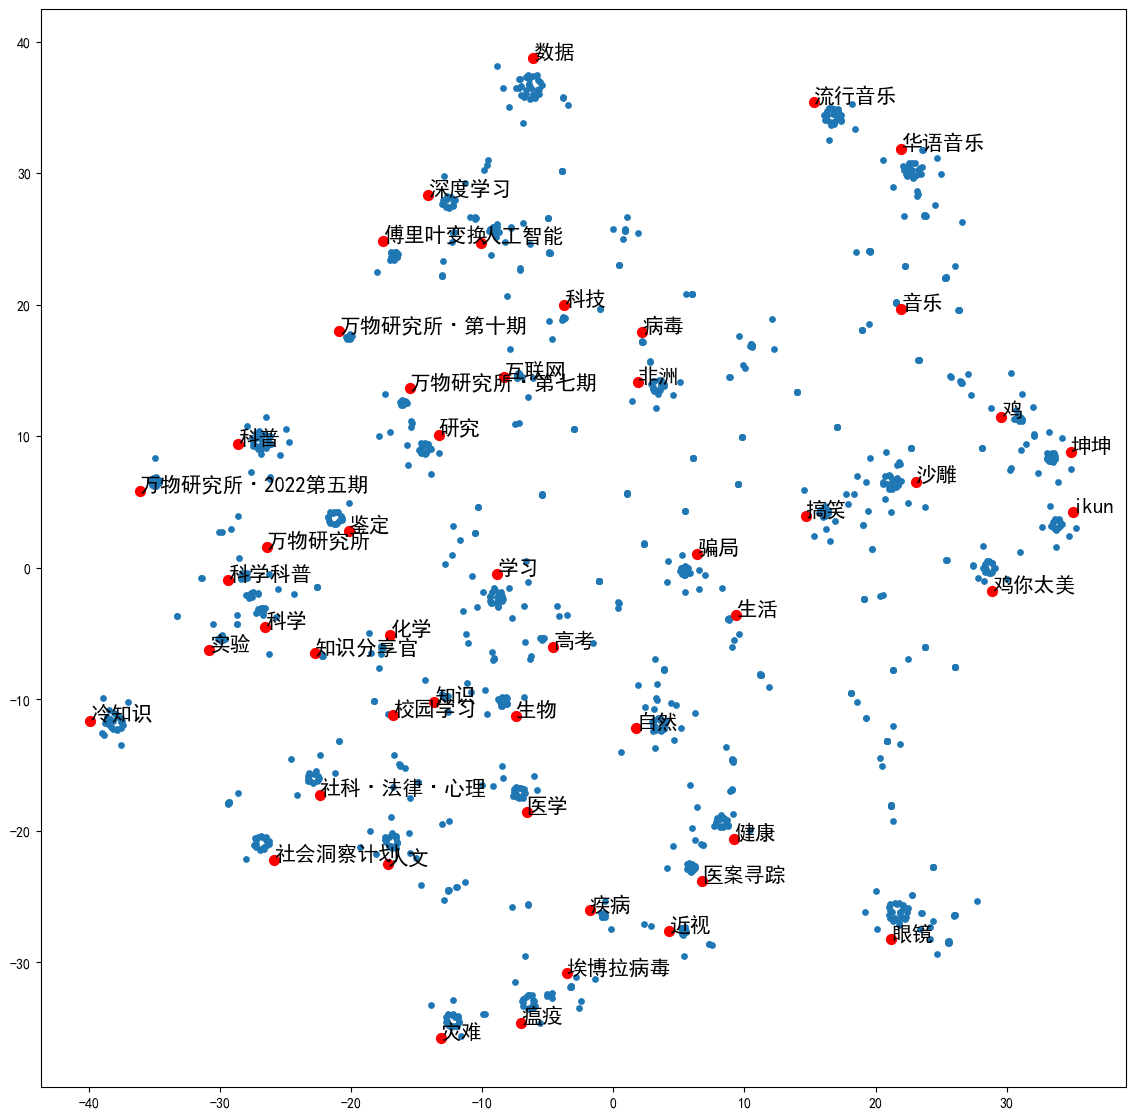

In [57]:
plt.figure(figsize=(14,14))
plt.scatter(embed_2d[:,0], embed_2d[:,1],s=15)

for item in terms_chosen:
    idx = term2index[item]
    plt.scatter(embed_2d[idx,0], embed_2d[idx,1],c='r',s=50)
    plt.annotate(item, xy=(embed_2d[idx,0], embed_2d[idx,1]),c='k',fontsize=15)
plt.show()

In [46]:
embed_2d.shape

(1234, 2)

### 导出TSNE降维到二维之后的Embedding

In [47]:
terms_chosen_mask = np.zeros(X.shape[0])
for item in terms_chosen:
    idx = term2index[item]
    terms_chosen_mask[idx] = 1

In [48]:
df = pd.DataFrame()
df['X'] = embed_2d[:,0]
df['Y'] = embed_2d[:,1]
df['item'] = model.wv.index_to_key
df['pagerank'] = pagerank.values()
df['chosen'] = terms_chosen_mask

In [49]:
df

,X,Y,item,pagerank,chosen
0,-28.595535,9.394134,科普,0.005514,1.0
1,-13.661161,-10.213836,知识,0.007057,1.0
2,-6.135385,38.727604,数据,0.015731,1.0
3,-8.864642,-0.496154,学习,0.010548,1.0
4,21.201183,-28.260765,眼镜,0.000278,1.0
...,...,...,...,...,...
1229,8.750114,-3.883238,白日梦想家,0.000282,0.0
1230,-27.233292,9.888939,早教,0.000282,0.0
1231,-12.910233,-9.756808,常识,0.000282,0.0
1232,-13.074399,-9.625574,好奇心计划,0.000271,0.0


In [50]:
df.to_csv('./res/b站科技区_node2vec_2d.csv',index=False)